In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import linear_model
from scipy.interpolate import interp1d
import scipy.stats
import sklearn
print(sklearn.__version__)
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import median_absolute_error, PrecisionRecallDisplay, PredictionErrorDisplay, RocCurveDisplay
from load_data import *
import matplotlib.colors as mcolors

1.2.0


In [3]:
batch_train, batch_test, batch_val, batch_reject = load_batches('../dataset/')
batch_all = {**batch_train, **batch_test, **batch_val, **batch_reject}

In [4]:
for k in batch_all:
    print(batch_all[k].keys())
    print(batch_all[k]['summary'].keys())
    break

dict_keys(['cycle_life', 'charge_policy', 'summary', 'cycles'])
dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])


In [5]:
# calculate the discharge curve against voltage:
def discharge_curve(batches, batch_idx, cycle, clean=True):
    qds = np.array(batches[batch_idx]['cycles'][cycle]['Qd'])
    vs = np.array(batches[batch_idx]['cycles'][cycle]['V'])
    if not clean:
        return vs, qds

    # filter out samples that don't make sense by finding the first
    # maximum and subsequent minimum and only consider that range
    start = np.argmax(vs)
    end = np.argmin(vs[start:]) + start
    vs = vs[start:end]
    qds = qds[start:end]
    return vs, qds

Before cleaning:
(1061,) (1041,)
After cleaning:
(508,) (509,)


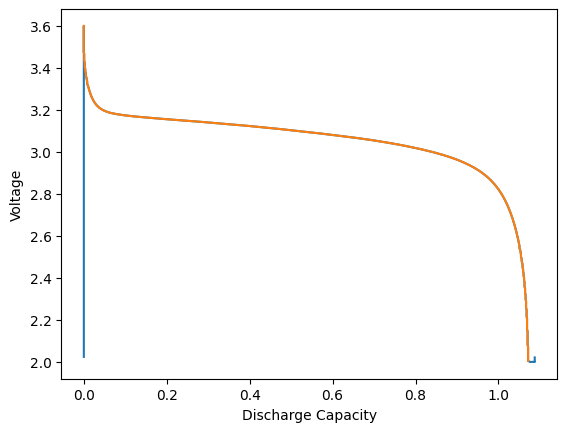

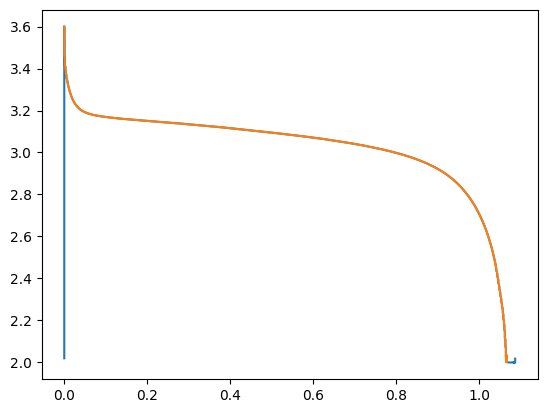

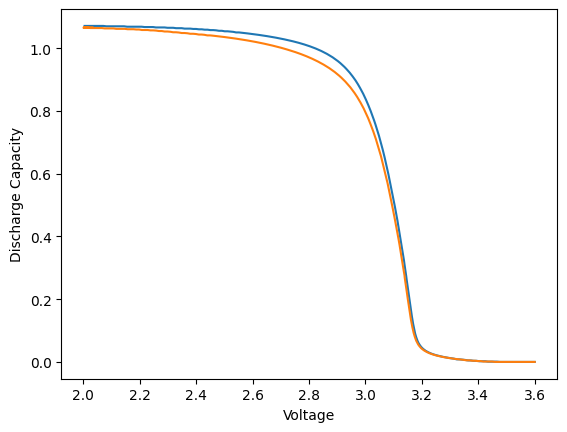

In [6]:
batch = 'b1c19'
vs1d, qds1d = discharge_curve(batch_all, batch, '10', False)
vs2d, qds2d = discharge_curve(batch_all, batch, '100', False)
vs1c, qds1c = discharge_curve(batch_all, batch, '10')
vs2c, qds2c = discharge_curve(batch_all, batch, '100')

print("Before cleaning:")
print(vs1d.shape, vs2d.shape)
print("After cleaning:")
print(vs1c.shape, vs2c.shape)

# plot original curves
plt.xlabel('Discharge Capacity')
plt.ylabel('Voltage')
plt.plot(qds1d, vs1d)
plt.plot(qds1c, vs1c)
plt.show()
plt.plot(qds2d, vs2d)
plt.plot(qds2c, vs2c)
plt.show()

# plot reversed curve
plt.xlabel('Voltage')
plt.ylabel('Discharge Capacity')
plt.plot(vs1c, qds1c)
plt.plot(vs2c, qds2c)

In [7]:
# use scipy.interplate.interp1d to re-sample the above curve in terms of V and THEN calculate the difference!

# get the discharge curve as a scipy object including min and max X values
def get_Qs(batches, batch_idx, cycle):
    vs, qds = discharge_curve(batches, batch_idx, cycle) 
    newF = interp1d(vs, qds)
    return newF, min(vs), max(vs)

#nsamples = number of samples for the discharge curve
def get_Qdiffs(batches, nsamples=1000):
    # the curves for cycle 10 and 100
    Q10s = np.array([get_Qs(batches, b, '10') for b in batches])
    Q100s = np.array([get_Qs(batches, b, '100') for b in batches])

    # calculate Q_100(V) - Q_10(V) for each run
    Qdiffs = []
    xvalues = []
    for q100, q10 in zip(Q100s, Q10s):
        # find the overlapping range
        start = max(q10[1], q100[1])
        end   = min(q10[2], q100[2])
        x = np.linspace(start, end, nsamples)
        # resample the curves and calculate Q100 - Q10
        curve10 = q10[0]
        curve100 = q100[0]
        Qdiffs.append(curve100(x) - curve10(x))
        xvalues.append(x)

    Qdiffs = np.array(Qdiffs)
    xvalues = np.array(xvalues)
    # print(Qdiffs.shape, xvalues.shape)
    return xvalues, Qdiffs

In [8]:
def get_variances(Qdiffs):
    # return (np.var(Qdiffs, axis=1))
    return np.abs(np.var(Qdiffs, axis=1))

def get_minimums(Qdiffs):
    # return (np.min(Qdiffs, axis=1))
    return np.abs(np.min(Qdiffs, axis=1))

def get_skwenesses(Qdiffs):
    # skewness ranges from -1.x to +0.x in this dataset.
    # in the paper they just take the absolute value from this but
    # that really messes up the distribution and it's not really
    # useful as a feature anymore.
    # instead, we just add 2 here to make it positive
    return 2 + (scipy.stats.skew(Qdiffs, axis=1))
    # return np.abs(scipy.stats.skew(Qdiffs, axis=1))

def get_kurtosises(Qdiffs):
    # return (scipy.stats.kurtosis(Qdiffs, axis=1, fisher=False))
    return np.abs(scipy.stats.kurtosis(Qdiffs, axis=1, fisher=False))

def get_cycle_lifes(batches):
    return np.array([batches[b]['cycle_life'] for b in batches]).flatten()

[2160. 1434. 1074.  870.  788.  719.  857.  788.  559. 1017.  870.  860.
  709.  731.  742.  704.  617.  966.  702.  616.  300.  438.  444.  511.
  477.  483.  494.  461.  489.  527.  461.  468.  498.  492.  520.  463.
  478.  459.  429.  462.  487.]
[2160. 1434. 1074.  870.  788.  719.  857.  788.  559. 1017.  870.  860.
  709.  731.  742.  704.  617.  966.  702.  616.  300.  438.  444.  511.
  477.  483.  494.  461.  489.  527.  461.  468.  498.  492.  520.  463.
  478.  459.  429.  462.  487.]
[2160. 1434. 1074.  870.  788.  719.  857.  788.  559. 1017.  870.  860.
  709.  731.  742.  704.  617.  966.  702.  616.  300.  438.  444.  511.
  477.  483.  494.  461.  489.  527.  461.  468.  498.  492.  520.  463.
  478.  459.  429.  462.  487.]
[2160. 1434. 1074.  870.  788.  719.  857.  788.  559. 1017.  870.  860.
  709.  731.  742.  704.  617.  966.  702.  616.  300.  438.  444.  511.
  477.  483.  494.  461.  489.  527.  461.  468.  498.  492.  520.  463.
  478.  459.  429.  462.  48

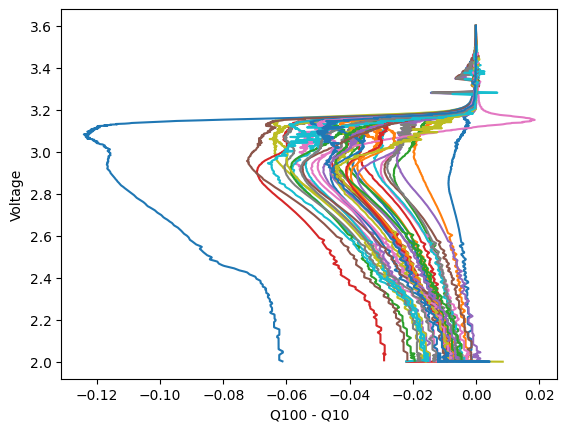

[1852. 2237. 1709.  636. 1054.  880.  862.  691.  534. 1014.  854.  842.
  917.  876.  757.  703.  648.  625. 1051.  651.  599.  148.  335.  480.
  561.  458.  485.  487.  502.  513.  495.  471.  509.  481.  519.  499.
  535.  465.  499.  466.  457.  429.  713.]
[1852. 2237. 1709.  636. 1054.  880.  862.  691.  534. 1014.  854.  842.
  917.  876.  757.  703.  648.  625. 1051.  651.  599.  148.  335.  480.
  561.  458.  485.  487.  502.  513.  495.  471.  509.  481.  519.  499.
  535.  465.  499.  466.  457.  429.  713.]
[1852. 2237. 1709.  636. 1054.  880.  862.  691.  534. 1014.  854.  842.
  917.  876.  757.  703.  648.  625. 1051.  651.  599.  148.  335.  480.
  561.  458.  485.  487.  502.  513.  495.  471.  509.  481.  519.  499.
  535.  465.  499.  466.  457.  429.  713.]
[1852. 2237. 1709.  636. 1054.  880.  862.  691.  534. 1014.  854.  842.
  917.  876.  757.  703.  648.  625. 1051.  651.  599.  148.  335.  480.
  561.  458.  485.  487.  502.  513.  495.  471.  509.  481.  519

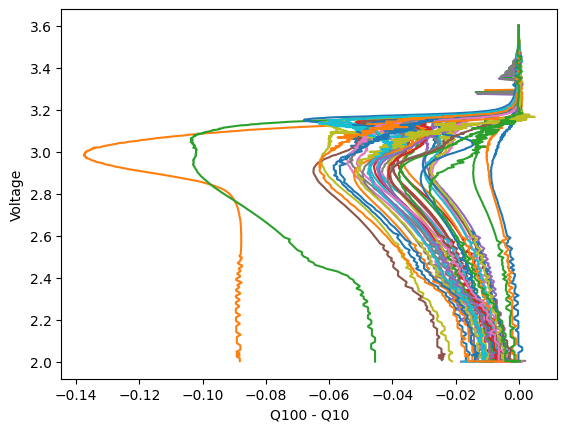

[1009. 1063. 1115. 1048.  828.  667. 1836.  828. 1039. 1078.  817.  932.
  816.  858.  876. 1638. 1315. 1146. 1155.  813.  772. 1002.  825.  989.
 1028.  850.  541.  858.  935.  731. 1284. 1158. 1093.  923. 1935. 1156.
  796.  786.  940. 1801.]
[1009. 1063. 1115. 1048.  828.  667. 1836.  828. 1039. 1078.  817.  932.
  816.  858.  876. 1638. 1315. 1146. 1155.  813.  772. 1002.  825.  989.
 1028.  850.  541.  858.  935.  731. 1284. 1158. 1093.  923. 1935. 1156.
  796.  786.  940. 1801.]
[1009. 1063. 1115. 1048.  828.  667. 1836.  828. 1039. 1078.  817.  932.
  816.  858.  876. 1638. 1315. 1146. 1155.  813.  772. 1002.  825.  989.
 1028.  850.  541.  858.  935.  731. 1284. 1158. 1093.  923. 1935. 1156.
  796.  786.  940. 1801.]
[1009. 1063. 1115. 1048.  828.  667. 1836.  828. 1039. 1078.  817.  932.
  816.  858.  876. 1638. 1315. 1146. 1155.  813.  772. 1002.  825.  989.
 1028.  850.  541.  858.  935.  731. 1284. 1158. 1093.  923. 1935. 1156.
  796.  786.  940. 1801.]
[1009. 1063. 1115. 1

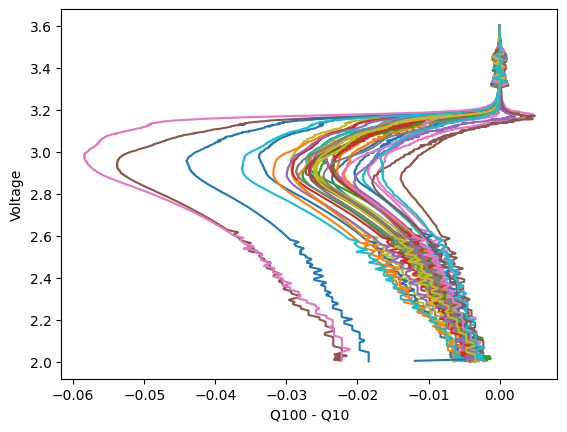

In [9]:
# graphs from the paper
for batch in [batch_train, batch_test, batch_val]:
    plt.xlabel('Q100 - Q10')
    plt.ylabel('Voltage')
    xvalues, Qdiffs = get_Qdiffs(batch)
    for y, x in zip(xvalues, Qdiffs):
        plt.plot(x, y)
        print(get_cycle_lifes(batch))
    plt.show()


C:\Users\GauDennisIPCampGmbH\AppData\Local\Temp\ipykernel_16168\724324891.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


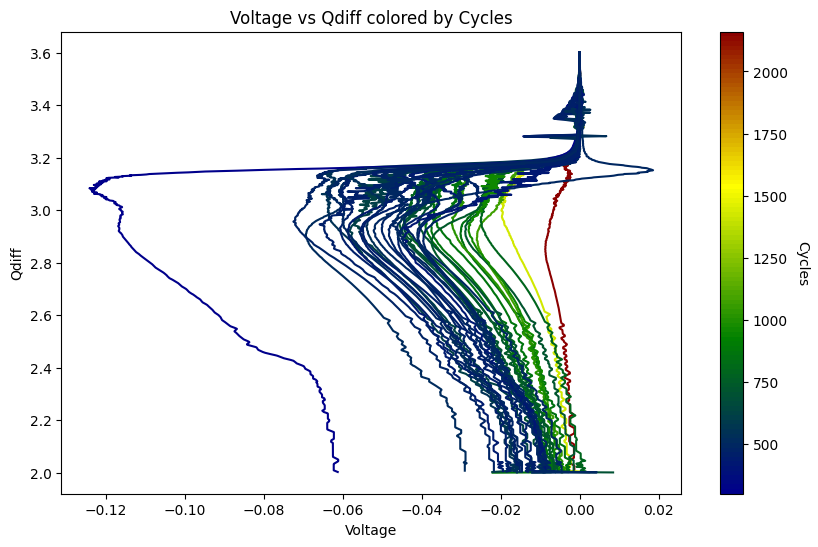

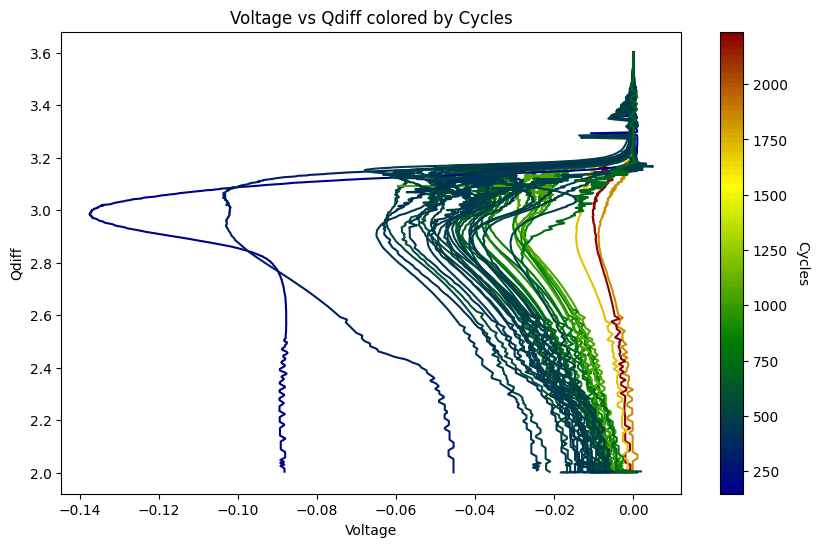

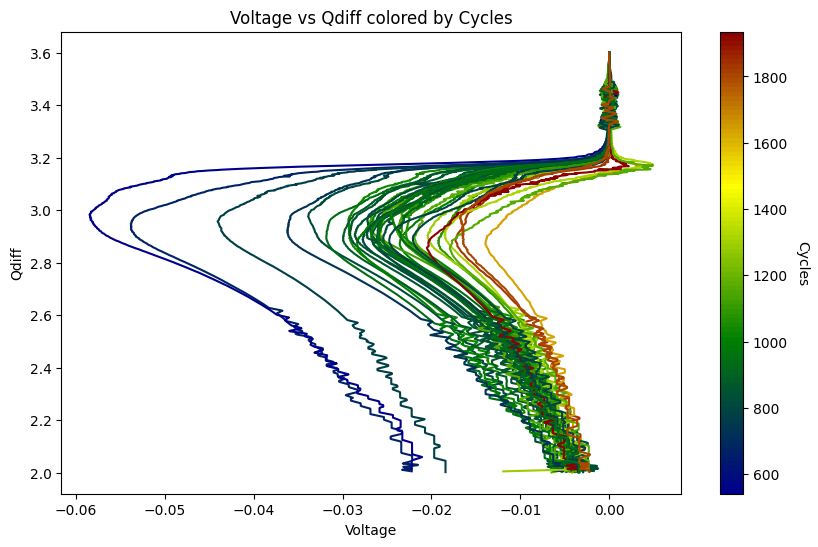

In [15]:
for batch in [batch_train, batch_test, batch_val]:
    xvalues, Qdiffs = get_Qdiffs(batch)
    cycles = get_cycle_lifes(batch)

    # Create the custom colormap
    colors = ["darkblue", "green", "yellow", "darkred"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=100)
    norm = plt.Normalize(min(cycles), max(cycles))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    for x, y, c in zip(Qdiffs, xvalues, cycles):
        ax.plot(x, y, color=cmap(norm(c)), label=f'Cycle {c}')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Cycles', rotation=270, labelpad=15)

    ax.set_xlabel('Voltage')
    ax.set_ylabel('Qdiff')
    #ax.legend()
    plt.title('Voltage vs Qdiff colored by Cycles')
    plt.show()

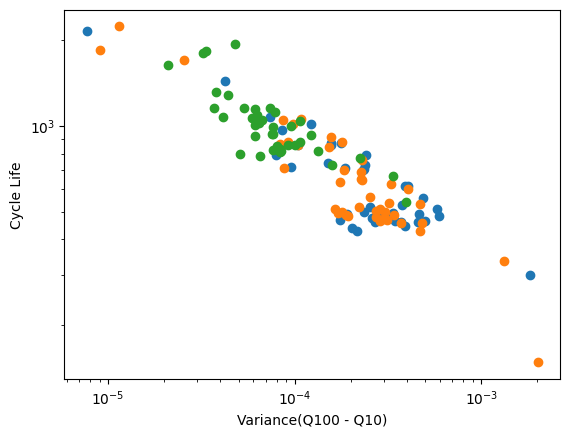

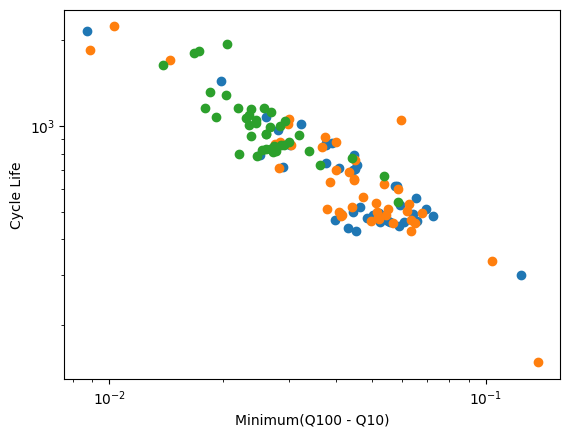

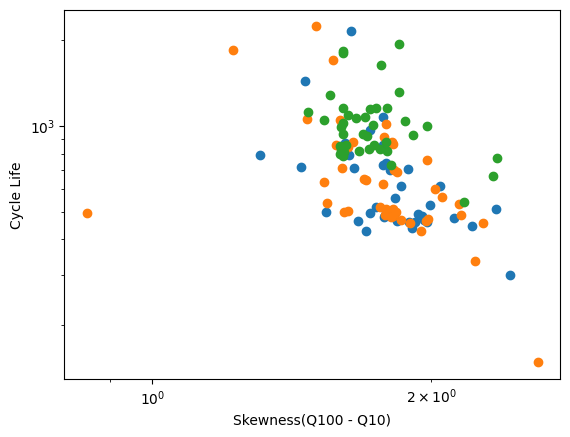

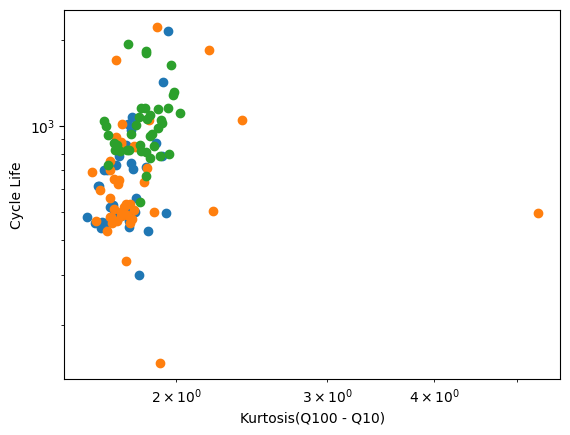

In [9]:
# graphs from the paper
features = {
    'Variance': get_variances,
    'Minimum': get_minimums,
    'Skewness': get_skwenesses,
    'Kurtosis': get_kurtosises
}
for feat, feat_func in features.items():
    for batch in [batch_train, batch_test, batch_val]:
        xvalues, Qdiffs = get_Qdiffs(batch)
        fvalues = feat_func(Qdiffs)
        lifes = get_cycle_lifes(batch)
        plt.scatter(fvalues, lifes)

    plt.xlabel(f'{feat}(Q100 - Q10)')
    plt.ylabel('Cycle Life')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [10]:
# build the features
feature_functions = features.values()
# feature_functions = (get_variances, get_minimums)
# feature_functions = (get_variances,)

Qdiffs_train = get_Qdiffs(batch_train)[1]
Qdiffs_test = get_Qdiffs(batch_test)[1]
Qdiffs_val = get_Qdiffs(batch_val)[1]

X_train = np.stack([f(Qdiffs_train) for f in feature_functions], axis=1)
X_test  = np.stack([f(Qdiffs_test) for f in feature_functions], axis=1)
X_val   = np.stack([f(Qdiffs_val) for f in feature_functions], axis=1)
y_train = get_cycle_lifes(batch_train).reshape(-1, 1)
y_test  = get_cycle_lifes(batch_test).reshape(-1, 1)
y_val   = get_cycle_lifes(batch_val).reshape(-1, 1)
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)


(41, 4) (43, 4) (40, 4)
(41, 1) (43, 1) (40, 1)


In [11]:
# transform all features into log space (for visualization)
X_trainlog = np.log(X_train)
y_trainlog = np.log(y_train)
X_testlog = np.log(X_test)
y_testlog = np.log(y_test)
X_vallog = np.log(X_val)
y_vallog = np.log(y_val)

# rescale features
# scaler = StandardScaler()
# scaler = scaler.fit(X_train)
# X_trainS = scaler.transform(X_train)
# X_testS = scaler.transform(X_test)
# X_valS = scaler.transform(X_val)
# print(scaler.scale_, scaler.mean_, scaler.var_)


   Cycle Life  Variance   Minimum  Skewness  Kurtosis dataset
0      2160.0  0.000008  0.008727  1.638973  1.956556   Train
1      1434.0  0.000043  0.019817  1.462503  1.928720   Train
2      1074.0  0.000074  0.026067  1.775548  1.777133   Train
3       870.0  0.000158  0.037615  1.614427  1.895223   Train
4       788.0  0.000080  0.025085  1.305857  1.925948   Train


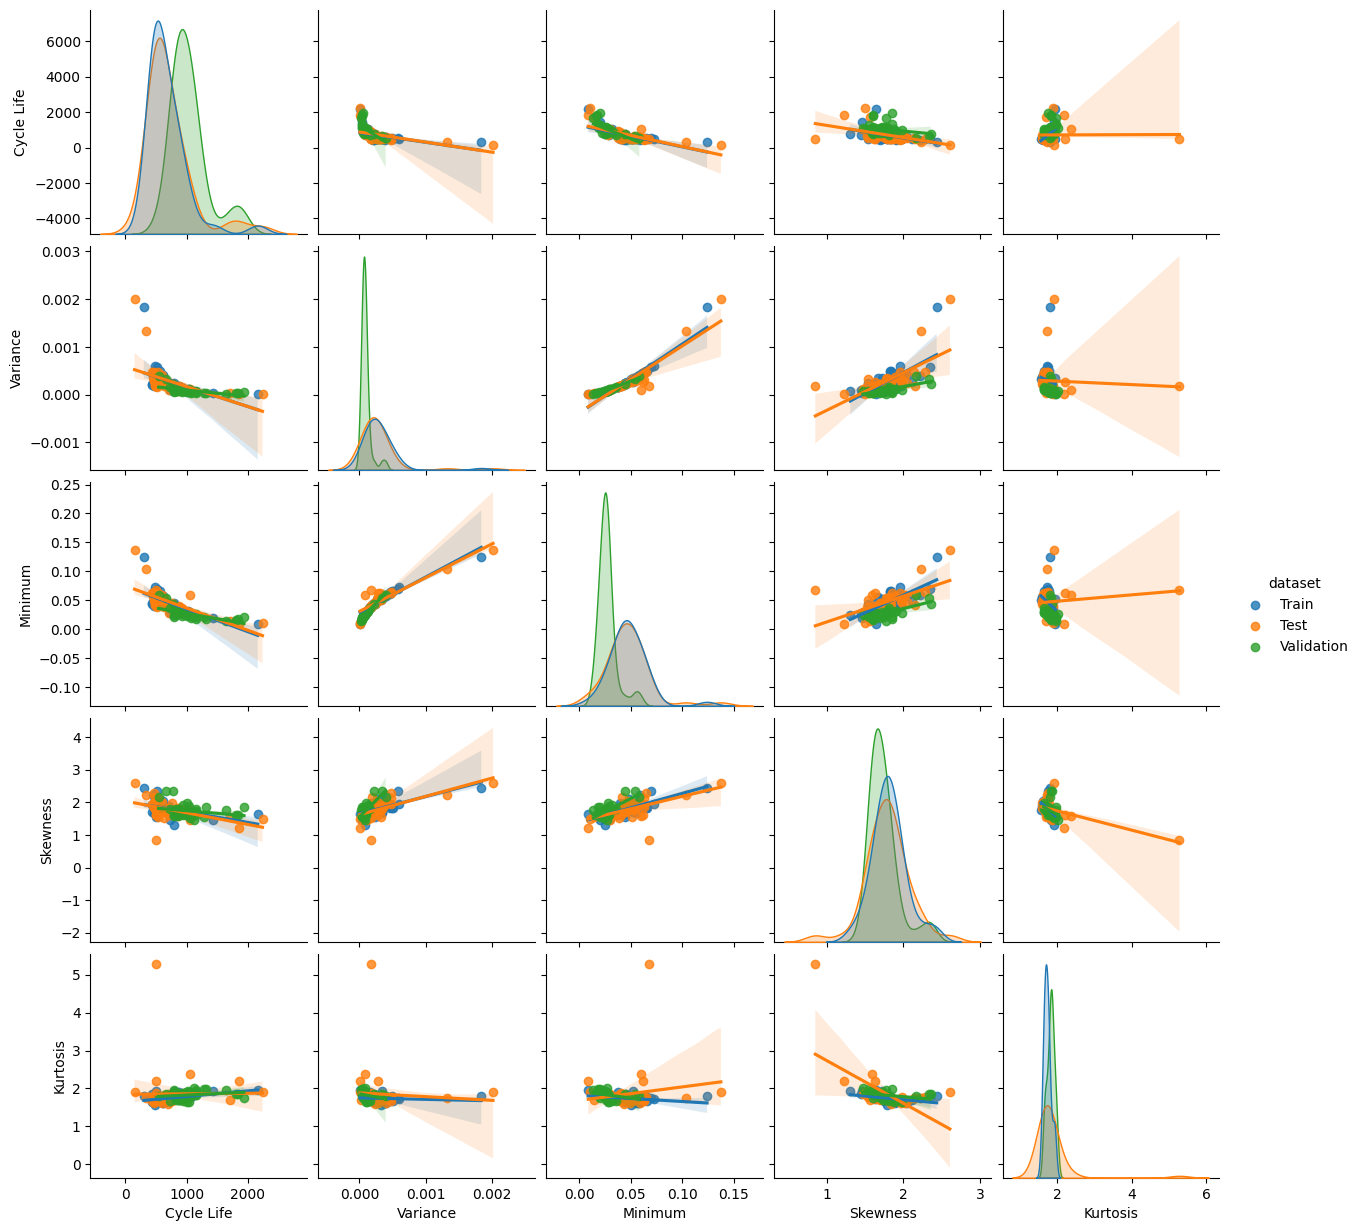

   Cycle Life   Variance   Minimum  Skewness  Kurtosis dataset
0    7.677864 -11.774065 -4.741320  0.494070  0.671186   Train
1    7.268223 -10.065054 -3.921217  0.380150  0.656857   Train
2    6.979145  -9.517140 -3.647067  0.574109  0.575002   Train
3    6.768493  -8.755814 -3.280365  0.478980  0.639337   Train
4    6.669498  -9.436049 -3.685478  0.266860  0.655418   Train


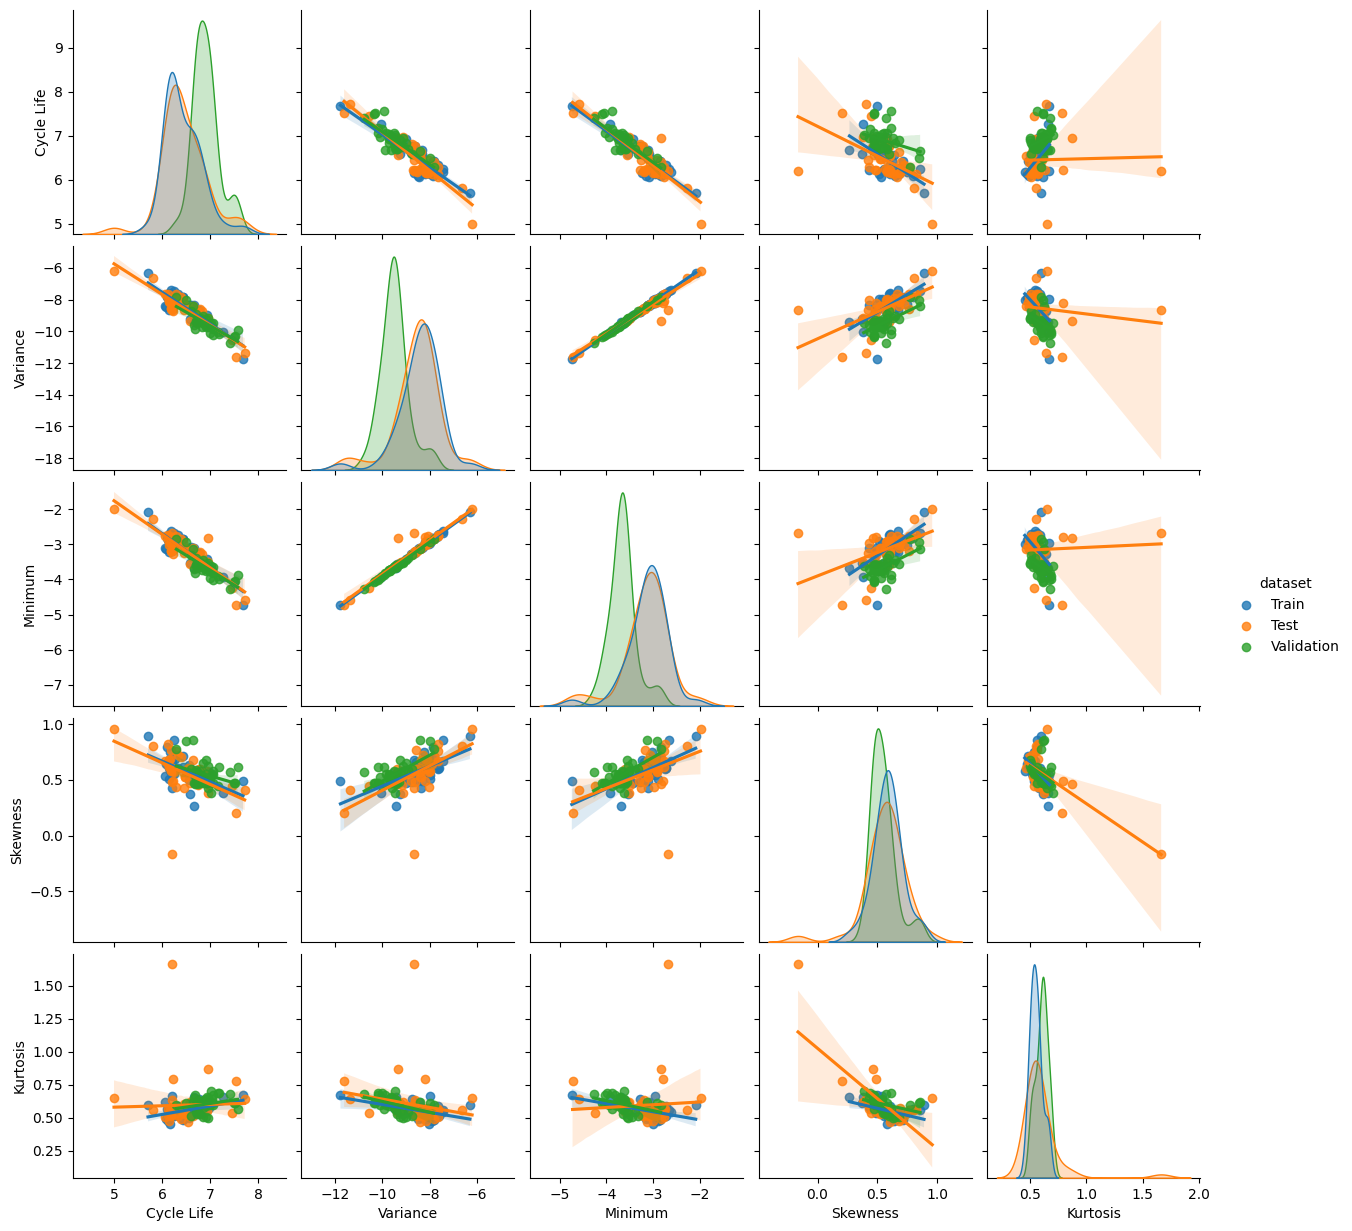

In [12]:
# visualize training features
def visualize(X1, y1, X2, y2, X3, y3):
    names = ['Cycle Life','Variance','Minimum','Skewness','Kurtosis']
    arr1 = np.concatenate((y1, X1), axis=1)
    arr2 = np.concatenate((y2, X2), axis=1)
    arr3 = np.concatenate((y3, X3), axis=1)
    frame1 = pd.DataFrame(arr1, columns=names).assign(dataset='Train')
    frame2 = pd.DataFrame(arr2, columns=names).assign(dataset='Test')
    frame3 = pd.DataFrame(arr3, columns=names).assign(dataset='Validation')
    frame = pd.concat([frame1, frame2, frame3])
    print(frame.head())
    sns.pairplot(frame, kind='reg', diag_kind='kde', hue='dataset')
    plt.show()

visualize(X_train, y_train, X_test, y_test, X_val, y_val)
visualize(X_trainlog, y_trainlog, X_testlog, y_testlog, X_vallog, y_vallog)
# visualize(X_trainS, y_train, X_testS, y_test)

In [13]:
# train models using pipeline
models = {
    'Linear ': linear_model.LinearRegression(),
    'Ridge  ': linear_model.Ridge(),
    # 'RidgeCV': linear_model.RidgeCV(),
    # 'Lasso  ': linear_model.Lasso(),
    # 'ElasticNet 1': linear_model.ElasticNet(alpha=0.5   , l1_ratio=0.01, random_state=False),
    'ElasticNet 2': linear_model.ElasticNet(alpha=0.5   , l1_ratio=0.02, random_state=False),
    # 'ElasticNet 3': linear_model.ElasticNet(alpha=0.5   , l1_ratio=0.03, random_state=False),
}

def pipe(model):
    return sklearn.pipeline.make_pipeline(
        FunctionTransformer(np.log),
        StandardScaler(),
        TransformedTargetRegressor(regressor=model, func=np.log, inverse_func=np.exp)
    )

pipelines = {k: pipe(v) for k, v in models.items()}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    print(f'{name}: score: {pipe.score(X_test, y_test)}')
    print(f'{name}: coeffs: {pipe[-1].regressor_.coef_}  intercept: {pipe[-1].regressor_.intercept_}')

    mae_train = median_absolute_error(y_train, pipe.predict(X_train))
    y_pred = pipe.predict(X_test)
    mae_test = median_absolute_error(y_test, y_pred)
    print(f'{name}: MedAE training : {mae_train:.2f}\n{name}: MedAE test     : {mae_test:.2f}')
    # disp = PredictionErrorDisplay.from_predictions(y_test, y_pred, kind='actual_vs_predicted')
    # plt.show()

Linear : score: 0.7987046875906739
Linear : coeffs: [ 0.31229911 -0.63857642  0.01569037  0.01483882]  intercept: 6.433353436588338
Linear : MedAE training : 93.63
Linear : MedAE test     : 80.26
Ridge  : score: 0.850955943129911
Ridge  : coeffs: [-0.13047047 -0.1801511  -0.00355269  0.01352689]  intercept: 6.433353436588338
Ridge  : MedAE training : 89.23
Ridge  : MedAE test     : 83.90
ElasticNet 2: score: 0.7198585614853733
ElasticNet 2: coeffs: [-0.11321022 -0.11481546 -0.02962602  0.02085383]  intercept: 6.433353436588338
ElasticNet 2: MedAE training : 99.91
ElasticNet 2: MedAE test     : 90.59


In [14]:
#train models manually
models = {
    'Linear ': linear_model.LinearRegression(),
    'Ridge  ': linear_model.Ridge(),
    # 'RidgeCV': linear_model.RidgeCV(),
    # 'Lasso  ': linear_model.Lasso(),
    'ElasticNet': linear_model.ElasticNet(alpha=0.5, l1_ratio=0.02, random_state=False),
}

scaler2 = StandardScaler()
scaler2.fit(X_trainlog)
X_trainS = scaler2.transform(X_trainlog)
X_testS = scaler2.transform(X_testlog)
print(X_trainlog.shape, X_trainS.shape)
print("Scaler: ", scaler2.scale_, scaler2.mean_, scaler2.n_features_in_, scaler2.n_samples_seen_)


for name, pipe in models.items():
    pipe.fit(X_trainS, y_trainlog)
    print(f'{name}:\tscore: {pipe.score(X_testS, y_testlog)}')
    print(f'{name}:\tcoeffs: {pipe.coef_}  intercept: {pipe.intercept_}')

    mae_train = median_absolute_error(y_train, np.exp(pipe.predict(X_trainS)))
    y_pred = np.exp(pipe.predict(X_testS))
    mae_test = median_absolute_error(y_test, y_pred)
    print(f'MedAE training : {mae_train:.2f}\nMedAE test     : {mae_test:.2f}')
    # disp = PredictionErrorDisplay.from_predictions(y_test, y_pred, kind='actual_vs_predicted')
    # plt.show()

(41, 4) (41, 4)
Scaler:  [0.8596336  0.41896086 0.12077115 0.05349568] [-8.41563796 -3.12236838  0.58672227  0.5524929 ] 4 41
Linear :	score: 0.6587648608749227
Linear :	coeffs: [[ 0.31229911 -0.63857642  0.01569037  0.01483882]]  intercept: [6.43335344]
MedAE training : 93.63
MedAE test     : 80.26
Ridge  :	score: 0.7966346956589302
Ridge  :	coeffs: [[-0.13047047 -0.1801511  -0.00355269  0.01352689]]  intercept: [6.43335344]
MedAE training : 89.23
MedAE test     : 83.90
ElasticNet:	score: 0.6912391589881763
ElasticNet:	coeffs: [-0.11321022 -0.11481546 -0.02962602  0.02085383]  intercept: [6.43335344]
MedAE training : 99.91
MedAE test     : 90.59


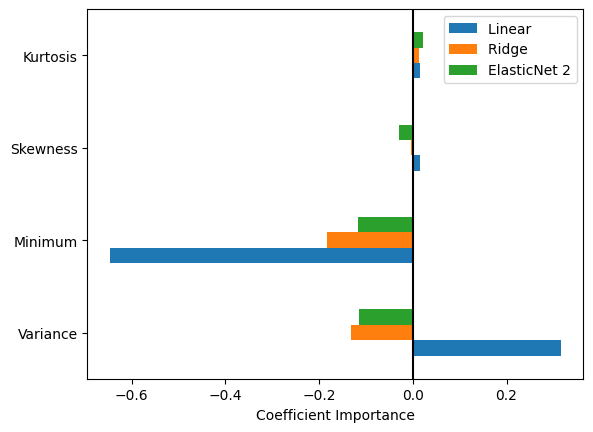

In [15]:
# show coefficient importance
coefs = pd.DataFrame()
for idx, (name, pipe) in enumerate(pipelines.items()):
    X_train_processed = pd.DataFrame(
        pipe[:-1].transform(X_train), columns=features.keys()
    )
    coefs[name] = pipe[-1].regressor_.coef_ * X_train_processed.std(axis=0)
    # coefs[name] = pipe[-1].regressor_.coef_

coefs.plot(kind='barh')
plt.xlabel('Coefficient Importance')
plt.axvline(x=0, color='black')
plt.show()

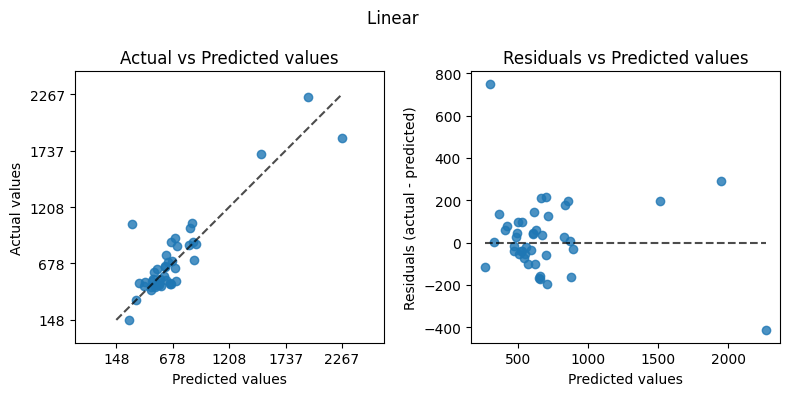

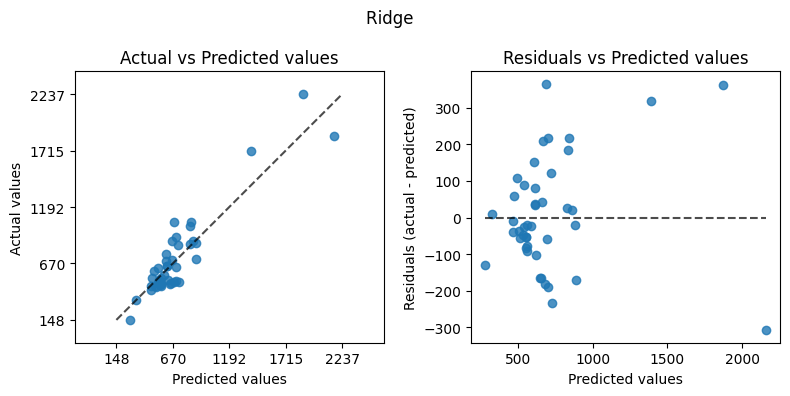

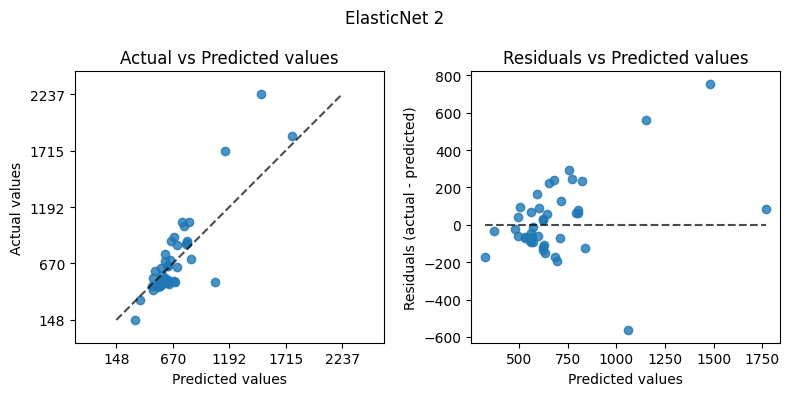

In [47]:
# show model stats
features = {
    'Variance': get_variances,
    'Minimum': get_minimums,
    'Skewness': get_skwenesses,
    'Kurtosis': get_kurtosises
}

# y_pred = np.stack([np.squeeze( pipe.predict(Xs) ) for pipe in pipelines.values()], axis=1)
for name, pipe in pipelines.items():
    fig, ax = plt.subplots(ncols=2, figsize=(8,4))
    PredictionErrorDisplay.from_estimator(pipe, X_test, y_test, ax=ax[0], kind='actual_vs_predicted')
    PredictionErrorDisplay.from_estimator(pipe, X_test, y_test, ax=ax[1], kind='residual_vs_predicted')
    ax[0].set_title('Actual vs Predicted values')
    ax[1].set_title('Residuals vs Predicted values')
    fig.suptitle(f'{name}')
    plt.tight_layout()
    plt.plot()

In [28]:
# show prediction line on top of dataset
features = {
    'Variance': get_variances,
    'Minimum': get_minimums,
    'Skewness': get_skwenesses,
    'Kurtosis': get_kurtosises
}

def visualize(scale):
    batch = {**batch_train, **batch_test, **batch_val}

    # the dataset
    Qdiffs = get_Qdiffs(batch)[1]
    fvalues = np.stack([f(Qdiffs) for f in features.values()], axis=1)
    lifes = get_cycle_lifes(batch)
    print('Qdiffs:', Qdiffs.shape)
    print('fvalues:', fvalues.shape)
    print('lifes:', lifes.shape)

    # the regression results
    # Xs = np.linspace(np.min(fvalues, axis=0), np.max(fvalues, axis=0), 1000)
    Xs = np.linspace(np.min(fvalues, axis=0), np.max(fvalues, axis=0), 100)
    print('Xs: ', Xs.shape)
    X2 = np.split(Xs, 4, axis=1)
    print('X2: ', len(X2), X2[0].shape)
    X3 = np.meshgrid(X2)
    print('X3: ', X3[0].shape)
    X4 = np.meshgrid(Xs[:,0], Xs[:,1], Xs[:,2], Xs[:,3])
    print('X4: ', X4[0].shape)
    X5 = np.rollaxis(X4[0], 0, 4)
    X5 = X5.reshape((100*100*100*100, 4))
    print('X5: ', X5.shape)

    ys = np.stack([np.squeeze( pipe.predict(Xs) ) for pipe in pipelines.values()], axis=1)
    print('Xs: ', Xs.shape)
    print('ys: ', ys.shape)
    return

    for fidx, feat in enumerate(features):
        # draw the feature from the dataset
        plt.scatter(fvalues[:, fidx], lifes, color='lightgray')

        # draw the regression results on the dataset
        for midx, name in enumerate(pipelines):
            plt.plot(Xs[:, fidx], ys[:, midx], label=name)

        plt.xlabel(f'{feat}(Q100 - Q10) ({scale})')
        plt.ylabel(f'Cycle Life ({scale})')
        plt.xscale(scale)
        plt.yscale(scale)
        plt.legend()
        plt.show()

visualize('linear')
visualize('log')

Qdiffs: (124, 1000)
fvalues: (124, 4)
lifes: (124,)
Xs:  (100, 4)
X2:  4 (100, 1)
X3:  (400,)
X4:  (100, 100, 100, 100)


ValueError: cannot reshape array of size 100000000 into shape (1000000,4)